# particle-GAN

Before launching this notebook consider installing `crayimage` package:

```bash
pip install cython
```

and then

```bash
pip install git+https://github.com/yandexdataschool/crayimage.git@develop
```

or, to update:

```bash
pip install --no-deps --upgrade --force-reinstall git+https://github.com/yandexdataschool/crayimage.git@develop
```

![particle-GUN](http://vignette4.wikia.nocookie.net/memoryalpha/images/9/9d/Picard_damaged_by_compressed_teryon_beam.jpg/revision/latest?cb=20080523045613&path-prefix=en)

In [3]:
### don't forget to change THEANO_FLAGS
%env THEANO_FLAGS='device=cpu','floatX=float32'

%matplotlib nbagg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

import theano
import theano.tensor as T

from lasagne import *

import crayimage

import os
import os.path as osp

REAL_NORMALIZATION = 1024.0
MC_NORMALIZATION = 0.1

DATA_ROOT='.'
SHUFFLED_ROOT = '.'

VERSION = 'SGD'

SNAPSHOT_DIR = './%s' % VERSION

img_shape = (1, 128, 128)
noise_shape = (1, 144, 144)
geant_shape = (1, 142, 142)

env: THEANO_FLAGS='device=cpu','floatX=float32'


## Particle GAN

Particle GAN is a Deep Neural Network with skip-connections (similar to [U-net](http://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)) applied to transform a GEANT simplified Monte-Carlo samples into realistic data.

### Background generator

In [4]:
from crayimage.particle_GAN import BackgroundGenerator

background_net = BackgroundGenerator(input_shape=noise_shape)

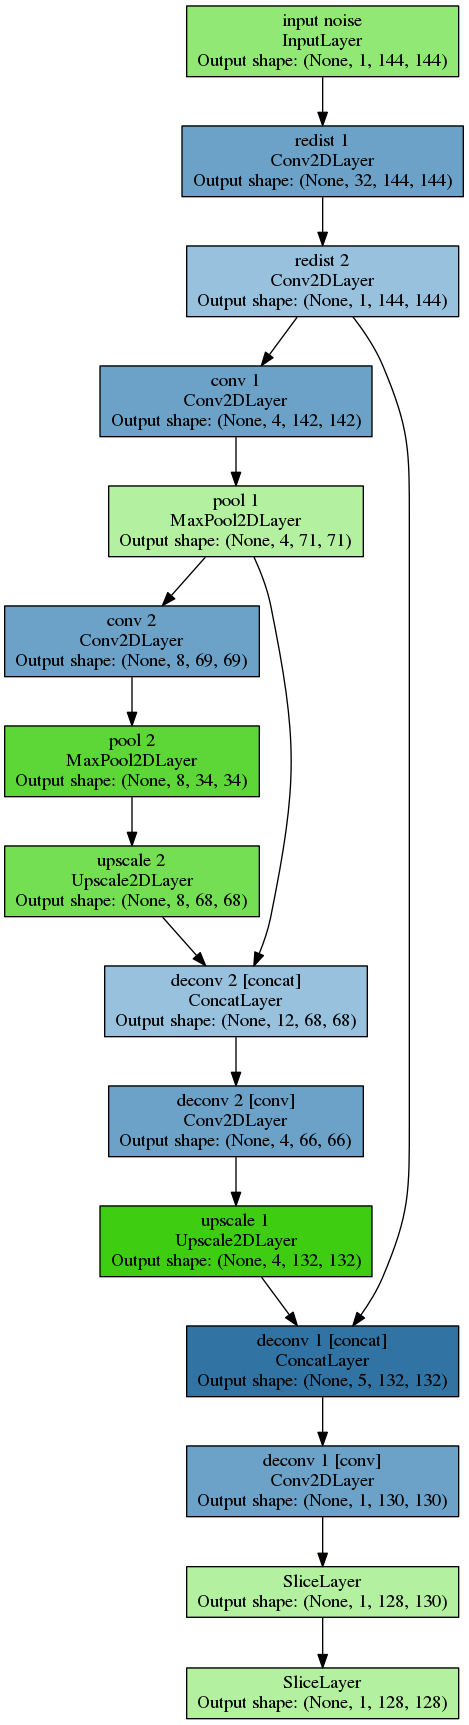

In [5]:
from crayimage.utils.visualize import draw_to_notebook

draw_to_notebook(layers.get_all_layers(background_net.net))

### Particle generator

In [6]:
from crayimage.particle_GAN import ParticleGenerator

In [7]:
particle_net = ParticleGenerator(input_shape=geant_shape)

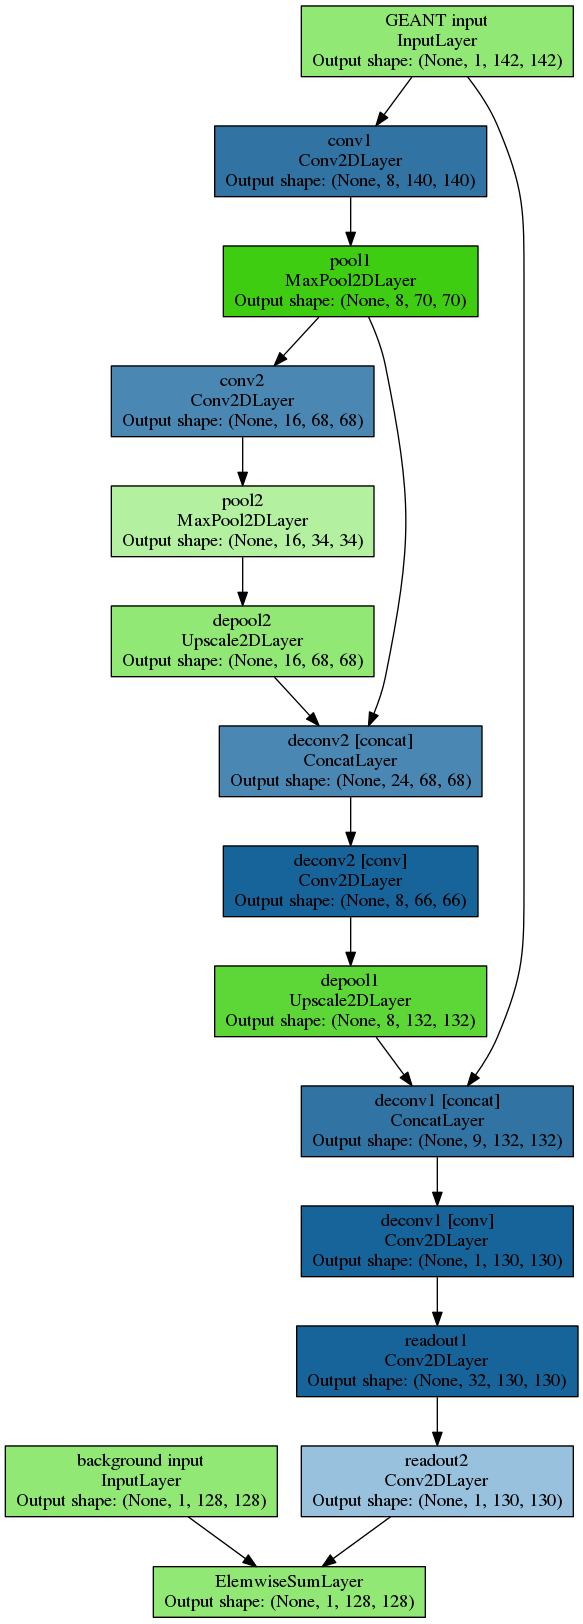

In [8]:
from crayimage.utils.visualize import draw_to_notebook

draw_to_notebook(layers.get_all_layers(particle_net.net))

In [9]:
from crayimage.particle_GAN import StairsDiscriminator

discriminator = StairsDiscriminator(depth = 5)

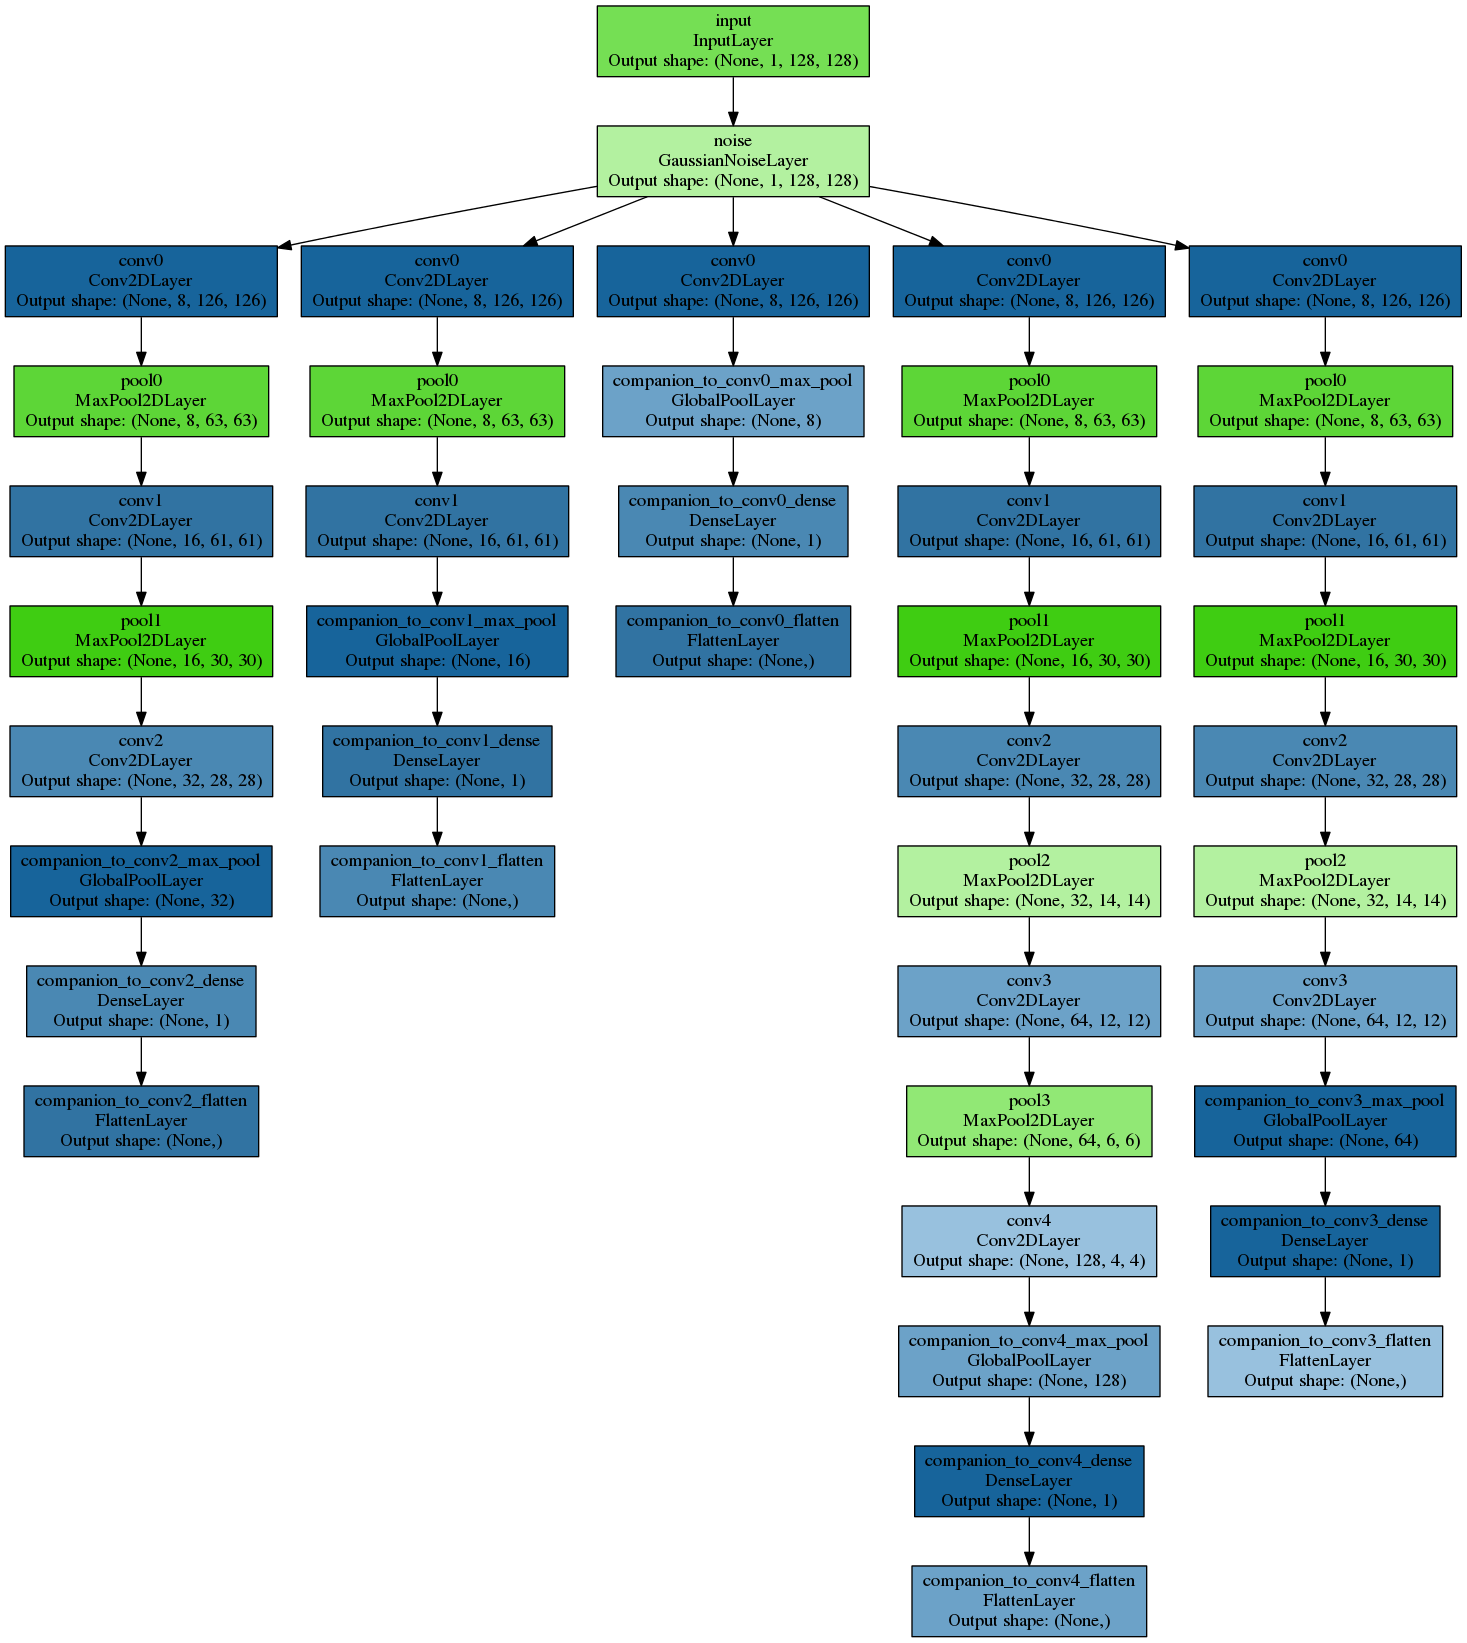

In [10]:
from crayimage.utils.visualize import draw_to_notebook

draw_to_notebook(
    layers.get_all_layers(discriminator.net)
)

In [11]:
particle_net.dump_dir = osp.join(SNAPSHOT_DIR, 'particle-net')
background_net.dump_dir = osp.join(SNAPSHOT_DIR, 'background-net')
discriminator.dump_dir = osp.join(SNAPSHOT_DIR, 'discriminator')

### Assembling GAN

#### Weights

Remember, weights are super important!

In [12]:
mc_batch_layout = (4, ) * 32
mc_batch_size = np.sum(mc_batch_layout)

n_real_bins = 22
real_tracks_batch_layout = (8, ) * n_real_bins

In [13]:
events_per_bin = np.array([1] * n_real_bins)

In [14]:
GEANT_NORMALIZATION=0.2
REAL_NORMALIZATION=1024.0

In [18]:
from crayimage.particle_GAN.particle_GAN import ParticleGAN

gan = ParticleGAN(
    background_net=background_net, particle_net=particle_net,
    discriminator = discriminator,
    mc_batch_layout = mc_batch_layout, real_batch_layout=real_tracks_batch_layout,
    real_events_per_bin = events_per_bin,
    geant_normalization = GEANT_NORMALIZATION, real_normalization=REAL_NORMALIZATION,
    minimal_loss_trick = True,
    anneal_discriminator=True
)

## Wiring the data

### GEANT

In [ ]:
DEPTH = 5.0

from crayimage.runutils import load_index
runs = load_index('sim-Co.json', DATA_ROOT)

In [ ]:
Co_run = runs['sim-Co']
Co_run.meta_info['depth'] = Co_run.meta_info['depth'].astype('float32')
Co_run.meta_info['energy'] = Co_run.meta_info['energy'].astype('float32')

Co_run = Co_run[Co_run.meta_info['depth'] == DEPTH]

In [ ]:
from crayimage.simulation.particle.geant import SimulationStream

sim_stream = SimulationStream.from_run(
    Co_run, spectrum=(1170.0, 1330.0),
    sizes = mc_batch_layout, img_shape=geant_shape[1:],
    cache = 128
)

In [ ]:
sim_batch = sim_stream.next()

In [ ]:
%timeit sim_stream.next()

In [ ]:
nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), squeeze=False)

indx = np.random.choice(sim_batch.shape[0], size=nrows*ncols, replace=False).reshape(nrows, ncols)

for i in xrange(nrows):
    for j in xrange(ncols):
        axs[i, j].grid('off')
        im = axs[i, j].imshow(sim_batch[indx[i, j]], interpolation='none', cmap=plt.cm.gray)
        axs[i, j].set_title('sample %d' % indx[i, j])
plt.tight_layout()

In [ ]:
mc_example = sim_batch[[0, -1, -10]].reshape((-1,) + geant_shape)

### Real data

In [ ]:
from crayimage.runutils import np_disk_stream

In [ ]:
import os.path as osp

real_stream = np_disk_stream(
    SHUFFLED_ROOT,
    batch_sizes=real_tracks_batch_layout,
    cache_size=256, mmap_mode='r'
)

In [ ]:
real_example = real_stream.next()

In [ ]:
%timeit real_stream.next()

In [ ]:
nrows, ncols = 1, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3), squeeze=False)

indx = np.random.choice(real_example.shape[0], size=nrows*ncols, replace=False).reshape(nrows, ncols)

for i in xrange(nrows):
    for j in xrange(ncols):
        axs[i, j].grid('off')
        axs[i, j].imshow(real_example[indx[i, j], 0], interpolation='none', cmap=plt.cm.gray)
        axs[i, j].set_title('sample %d' % indx[i, j])
plt.tight_layout()

## Sanity check

In [ ]:
s = X_real.eval({ X_real_raw : real_stream.next() })

In [ ]:
plt.figure()
plt.imshow(s[-9, 0])
plt.colorbar()

In [ ]:
s = X_geant.eval({ X_geant_raw : sim_stream.next().reshape(-1, 1, 142, 142) })

In [ ]:
plt.figure()
plt.imshow(s[-2, 0])
plt.colorbar()

## Training

In [ ]:
version = 'line_search'
load_latest = False

if load_latest:
    import re
    r = re.compile('particle_net_epoch=(\\d+)_version=%d' % version)
    
    try:
        latest = max([
            int(x)
            for item in os.listdir(SNAPSHOT_DIR)
            for x in r.findall(item)
        ])
        
        
        particle_net.load('particle_net_epoch=%d_version=%d' % (latest, version))
        background_net.load('background_net_epoch=%d_version=%d' % (latest, version))
        discriminator.reset()
    except Exception as e:
        import warnings
        warnings.warn('\nFailed to load latest version:\n%s' % str(e))

In [ ]:
img_watcher = crayimage.utils.img_watcher.ImgWatcher(
    n_rows=3, cmap1=plt.cm.gray, cmap2=plt.cm.gray,
    fig_size=4
)

In [ ]:
watcher = crayimage.utils.nn_watcher.NNWatcher(
    labels=('pseudo loss', ),
    colors=('blue', ),
    fig_size=(9, 4)
)

In [ ]:
n_cycles = 2 ** 20

n_batches_per_epoch = 64
n_epoches = n_cycles / n_batches_per_epoch

losses = np.zeros(shape=(n_epoches * n_batches_per_epoch))

DISCRIMINATOR_LOSS_THRESHOLD = 0.1

discriminator_phase = True

save_each = 2 ** 10

for cycle in xrange(n_cycles):
    if (cycle == 0) or (losses[cycle - 1] > DISCRIMINATOR_LOSS_THRESHOLD):
        geant_batch = sim_stream.next().reshape((-1,) + geant_shape)
        real_batch = real_stream.next()

        losses[cycle] = train_discriminator(geant_batch, real_batch, 1.0e-5, 1.0e-3)
    else:
        geant_batch = sim_stream.next().reshape((-1,) + geant_shape)
        losses[cycle] = train_generator(geant_batch, 5.0e-5)
    
    #rate_watcher.draw(event_rate[:(epoch + 1)])
    if cycle % n_batches_per_epoch == 0 and cycle > 0:
        watcher.draw(losses[:cycle].reshape(-1, n_batches_per_epoch))
        tr = get_realistic(mc_example)
        img_watcher.draw(mc_example[:, 0], tr[:, 0])
    
    if cycle % save_each == 0 and np.all(np.isfinite(losses)):
        particle_net.save(
            osp.join(SNAPSHOT_DIR, 'particle_net_epoch=%d_version=%s' % (cycle, str(version)))
        )

        background_net.save(
            osp.join(SNAPSHOT_DIR, 'background_net_epoch=%d_version=%s' % (cycle, str(version)))
        )